<a href="https://colab.research.google.com/github/ValentinoFr/ValentinoFr/blob/circleci-project-setup/Valentino_Light_curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Light curves

In this notebook you learn how to evaluate light curve models.

- Transit light curves
- Eclipse light curves
- Full phase curves

Python transit libraries written, maintained and used by the exoplanet community:
 - [pylightcurve](https://github.com/ucl-exoplanets/pylightcurve)
 - [batman](http://lkreidberg.github.io/batman/docs/html/index.html)
 - [pytransit](https://github.com/hpparvi/PyTransit)

In this notebook we use pylightcurve.

Start by mounting your Google drive, and import relevant libraries.

In [1]:
#!pip install pylightcurve

import numpy as np
from matplotlib import pyplot as plt
from astropy.io import ascii
from scipy.optimize import curve_fit
import sys, os
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Add to PYTHONPATH the path to local libraries
LOCALPATH = "/content/drive/My Drive/Planets/Copia di pythonlib_2023"
if not any(filter( lambda x: 'Copia di pythonlib_2023' in x, sys.path )) :
  sys.path.append(LOCALPATH)
  print("Added\n  \"{:s}\"\nto your PYTHONPATH".format(sys.path[-1]))
else:
  print('Path already defined')


import pylightcurve as plc

Mounted at /content/drive
Added
  "/content/drive/My Drive/Planets/Copia di pythonlib_2023"
to your PYTHONPATH
    Done!
    Done!
    Done!
Checking exotethys database...
    Done!
    Done!
Checking ephemerides database...
    Done!
    Done!
Checking photometry database...
    Done!
    Done!
Checking catalogues database...
	Updating:  ecc_planets.yaml
    Done!
	Updating:  ecc_stars.yaml
    Done!


In [2]:
#@title In this hidden cell, the Planck function is defined. Remember to run this cell.
from scipy import constants as const

def Planck(wl, T):
  """
  Parameters
  ----------
  wl: array
      wavelengths in micron
  T:  scalar
      Temperature in K

  Returns
  -------
  out: array
      The Planck function in units of W/m**2/sr/micron
  """

  wlm = 1e-6*wl
  arg = (const.h*const.c/const.k)/(T*wlm)
  norm = 2.0*const.h*const.c**2

  ret = norm/(np.exp(arg)-1.0)/wlm**5

  print('ret', 1.0e-6*ret)

  return 1.0e-6*ret





# Planet parameters
Planet parameters are retrieved from the database.

The equilibrium temperature is estimated assuming a tidally locked planet as
$$ T_p = T_* ~~^{4}\sqrt{ \frac{1-A_B}{\epsilon} \frac{R_*^2}{2 a^2}}$$

Where symbols have usual meaning and $\epsilon$ is the emissivity ($\epsilon =1$ for a blackbody radiator). Although $a$ is the semiradious axis divided by the radious of the star indicated in the program as $sma$ $over$ $rs$

The day and night side temperatures are estimated following Equations 1 and 2 of [Cowan, et al. (2007)](https://ui.adsabs.harvard.edu/abs/2007MNRAS.379..641C/abstract):

$$ T_{day} = T_p ~~^4\sqrt{1-\Gamma}$$
$$ T_{night} = T_p ~~^4\sqrt{\Gamma}$$

Where  $\Gamma$ quantifies the portion of the
absorbed stellar energy advected to the planet’s night-side ($\Gamma = 0$
for no redistribution; $\Gamma = 0.5$ for full redistribution)".

For planet HD 209458b below, it is assumed $\Gamma = 0.165$ such that $T_{day}- T_{night} \simeq 527$K as reported by [Zellem et al. (2014)](https://iopscience.iop.org/article/10.1088/0004-637X/790/1/53) (guarda qui)

For planet WASP 121b we assume $\Gamma = 0.018$ such that $T_{day}-T_{night} \simeq 1693$K.

-------------------------------------------------------------

HD 209458b's star is extremely similar to the Sun, same as the WASP 121b's star

In [3]:
#QUI STO INIZIALIZZANDO I PIANETI DA TENERE IN CONSIDERAZIONE, CARICANDO DAL DATABASE TUTTE LE INFO
#ASSEGNO ALLE VARIABILI I LORO ARGOMENTI

planet_name = 'HD 209458b' #also known as the hot jupiter
planet_name_1 = 'WASP 121b'

#When Gamma = 0.5 the difference is 0.0K due to the fact that in the equation Tday is 1-0.5=0.5 and Tnight is already 0.5.
Gamma = 0.165 #setted to 0.0 for the modulation
#When Gamma = 0.0 the Tnight is setted to 0.0K
Gamma_1 = 0.018 #per WASP 121b
#when Gamma_1 = 0.5 the difference in temperature for Tday and Tnight is 0.0

planet      = plc.get_planet(planet_name) #used for collect data from database
rp_over_rs  = planet.rp_over_rs #radious planet over radious star
sma_over_rs = planet.sma_over_rs #semiradious axis divided by the radious of the star
period      = planet.period
ecc         = planet.eccentricity
inc         = planet.inclination
albedo      = planet.albedo # Arbitrary
emissivity  = planet.emissivity
Tstar       = planet.stellar_temperature

Rstar       = 1.203 #riferito ai raggi solari

print('HD')
print('T star HD: ',Tstar, 'K', '\n')

planet_1      = plc.get_planet(planet_name_1) #used for collect data from database
rp_over_rs_1  = planet_1.rp_over_rs #radious planet over radious star
sma_over_rs_1 = planet_1.sma_over_rs #semiradious axis divided by the radious of the star
period_1      = planet_1.period
ecc_1         = planet_1.eccentricity
inc_1         = planet_1.inclination
albedo_1      = planet_1.albedo # Arbitrary
emissivity_1  = planet_1.emissivity
Tstar_1       = planet_1.stellar_temperature

Rstar_1 = 1.458 #raggi solari

print('WASP')
print('T star wasp: ', Tstar_1, 'K', '\n','------------')


#######

#I have used different Gamma in the program related to the planets and I reported them in the equation of Tday and Tnight

Tplanet     = Tstar * (0.5*(1-albedo)/emissivity)**(1/4)/np.sqrt(sma_over_rs)
Tday        = Tplanet*(1-Gamma)**(1/4)
Tnight      = Tplanet*Gamma**(1/4)+1.0e-20 #setted to adjust the parameters for the modulation
phi0        = 40.9 # deg #setted to 0.0 for the modulation
t0          = period/2

Tplanet_1     = Tstar_1 * (0.5*(1-albedo)/emissivity_1)**(1/4)/np.sqrt(sma_over_rs_1)
Tday_1        = Tplanet_1*(1-Gamma_1)**(1/4)
Tnight_1      = Tplanet_1*Gamma_1**(1/4)+1.0e-20 #setted to adjust the parameters for the modulation
phi0_1        = 40.9  #setted to 0.0 for the modulation
#phi0_1        = 88.49
t0_1          = period_1/2

Difference = Tday - Tnight
Difference_1 = Tday_1 - Tnight_1


print('HD 209458b \n')
print('T(planet) = {:.0f} K, Bond albedo = {:.2f}'. format(Tplanet, albedo))
print('T(day): {:.0f} K, T(night): {:.0f} K, Transit depth: {:.1f}%'.format(Tday, Tnight, 100*rp_over_rs**2))



print('the transit depth is the ratio squared b/w the radious of the planet divided by the radious of the star')

print('Difference b/w day and night temperature: ', int(Difference), 'K' )

print(ecc, period, inc, sma_over_rs, rp_over_rs, t0, )

print('Transit depth: ', (rp_over_rs)**2)

print('---------------------------------')

print('WASP 121b \n')
print('T(planet) = {:.0f} K, Bond albedo = {:.2f}'. format(Tplanet_1, albedo))
print('T(day): {:.0f} K, T(night): {:.0f} K, Transit depth: {:.1f}%'.format(Tday, Tnight, 100*rp_over_rs**2))

print('Difference b/w day and night temperature: ', int(Difference_1), 'K' )

print(ecc_1, period_1, inc_1, sma_over_rs_1, rp_over_rs_1, t0_1, )

print('Transit depth: ', (rp_over_rs_1)**2) #in teoria questo dovrebbe essere la profondità di transito o TRANSIT DEPTH




HD
T star HD:  6065.0 K 

WASP
T star wasp:  6459.0 K 
 ------------
HD 209458b 

T(planet) = 1655 K, Bond albedo = 0.15
T(day): 1582 K, T(night): 1055 K, Transit depth: 1.5%
the transit depth is the ratio squared b/w the radious of the planet divided by the radious of the star
Difference b/w day and night temperature:  527 K
0.0 3.52474955 86.71 8.76 0.12086 1.762374775
Transit depth:  0.0146071396
---------------------------------
WASP 121b 

T(planet) = 2692 K, Bond albedo = 0.15
T(day): 1582 K, T(night): 1055 K, Transit depth: 1.5%
Difference b/w day and night temperature:  1693 K
0.0 1.274924762 87.6 3.754 0.1245 0.637462381
Transit depth:  0.01550025


Filter assumed is the 2MASS ks band, centered at a wavelength of about $2.2\mu$m.

----------------------------------------------------------------

Il 2MASS KS (Two Micron All-Sky Survey Ks) è un filtro utilizzato in astronomia per osservazioni nel vicino infrarosso (NIR) a una lunghezza d'onda di circa $2.16 μm$.

Il filtro KS prende il nome dalla sua banda passante nel vicino infrarosso e fa parte di un grande progetto di rilevamento del cielo chiamato Two Micron All-Sky Survey (2MASS).


Il progetto 2MASS è stato condotto tra il 1997 e il 2001 e aveva l'obiettivo di mappare l'intero cielo in tre bande del vicino infrarosso: $J$ ($1,25 μm$ ), $H$ ($1,65 μm$) e $KS$ ($2,16 μm$).

Queste bande del vicino infrarosso sono state scelte perché attraversano regioni di spazio relativamente prive di polvere interstellare, che tende a ridurre la visibilità delle stelle a lunghezze d'onda più corte. Di conseguenza, il vicino infrarosso è utile per ottenere una vista meno oscurata della Via Lattea e di altre galassie.

In [4]:
#QUESTO BOX DEFINISCE IL FILTRO FOTOMETRICO

#Fp/Fs estimated using A=0.15, e=1.0 for filter 2mass_ks.
#PHOENIX models are only computed for solar metallicity stars. Setting stellar_metallicity = 0.

filter_list = ['JOHNSON_V', '2mass_j', 'irac2', '2mass_ks']
wl_list = [0.540, 1.25, 4.5, 2.2] # microns

for wl, filter in zip(wl_list, filter_list):
 print(wl, filter)

#filter = '2mass_ks' #check on the wiki about photometric
#wl = 2.2 #micron e dove wl sta per wavelenght / lunghezza d'onda

delta_t = 10.0/3600.0 # sampling interval. All time units are hours

T14    = planet.transit_duration(filter)
T14_1 = planet_1.transit_duration(filter)


print(T14)
print(T14_1, 'Calcolato in giorni che trasformato in ore sono circa 2,88 h, con check su sito https://exoplanetarchive.ipac.caltech.edu/overview/wasp%20121%20b#planet_WASP-121-b_collapsible')
print('The transit time is similar b/w HD 209458b and WASP 121b as reported above \n', "It's a characteristic of each individual planet, due to the orbit, the stellar dimension, the planet dimension. \n ")

tt = np.arange(0, period, delta_t)
tt_1 = np.arange(0, period_1, delta_t)
#print(len(tt_1))

phase = plc.planet_phase(period,t0,tt ) + 0.5
phase_1 = plc.planet_phase(period_1, t0_1, tt_1) + 0.5


ldc = planet.filter(filter).limb_darkening_coefficients #è il coefficiente che si da ad una stella o corpo celeste la cui luminosità decresce apparentemente man mano che ci si avvicina al bordo
ldc_1 = planet_1.filter(filter).limb_darkening_coefficients



#LC sta per light curve
LC_T = plc.transit(ldc, rp_over_rs, period, sma_over_rs, ecc, inc, 0.0, t0, tt ) #0.0 time of periastro, t0 and tt...
LC_T_1 = plc.transit(ldc_1, rp_over_rs_1, period_1, sma_over_rs_1, ecc_1, inc_1, 0.0, t0_1, tt_1 )

#help(plc.transit)

#ho riportato qui solo dei print necessari per capire le cose

#print(LC_T, '\n', ldc, '\n', rp_over_rs, '\n', period, '\n', sma_over_rs,'\n', ecc, '\n', inc)
#print(tt)
#print(len(LC_T))
#print('------')
#print( ldc_1, '\n', rp_over_rs_1, '\n', period_1, '\n', sma_over_rs_1,'\n', ecc_1, '\n', inc_1)
#print(LC_T_1)
#print(len(LC_T_1))

0.54 JOHNSON_V
1.25 2mass_j
4.5 irac2
2.2 2mass_ks
Fp/Fs estimated using A=0.15, e=1.0 for filter 2mass_ks.
PHOENIX models are only computed for solar metallicity stars. Setting stellar_metallicity = 0.
Fp/Fs estimated using A=0.15, e=1.0 for filter 2mass_ks.
0.12880185975555997
0.12231818777213037 Calcolato in giorni che trasformato in ore sono circa 2,88 h, con check su sito https://exoplanetarchive.ipac.caltech.edu/overview/wasp%20121%20b#planet_WASP-121-b_collapsible
The transit time is similar b/w HD 209458b and WASP 121b as reported above 
 It's a characteristic of each individual planet, due to the orbit, the stellar dimension, the planet dimension. 
 


1269
1269


(-0.05, 0.05)

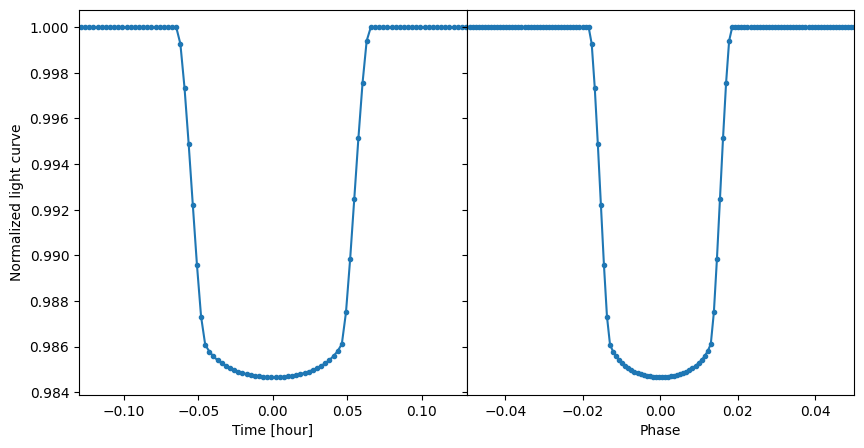

In [5]:
#HD 209458b

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,5))
fig.subplots_adjust(wspace=0)

print(len(tt))
print(len(LC_T))
ax0.plot(tt-1.762, LC_T, '.-') #shiftato e centrato in 0.0
ax0.set_xlabel('Time [hour]')
ax0.set_ylabel('Normalized light curve')
#ax0.set_xlim(t0-T14, t0+T14)
ax0.set_xlim(-0.13, 0.13)

ax1.plot(phase-0.5, LC_T, '.-') #in questo modo, con -0.5 ho centrato in zero la funzione
ax1.set_xlabel('Phase')
#ax1.set_xlim(0.5 - T14/planet.period, 0.5 + T14/planet.period) #per poter centrare la funzione
ax1.set_xlim(-0.05, 0.05)
#minore è l'inclinazione e più breve sarà il transito.
#ovvero, dal grafico LC/Phase possiamo vedere che

459
459


(-0.1, 0.1)

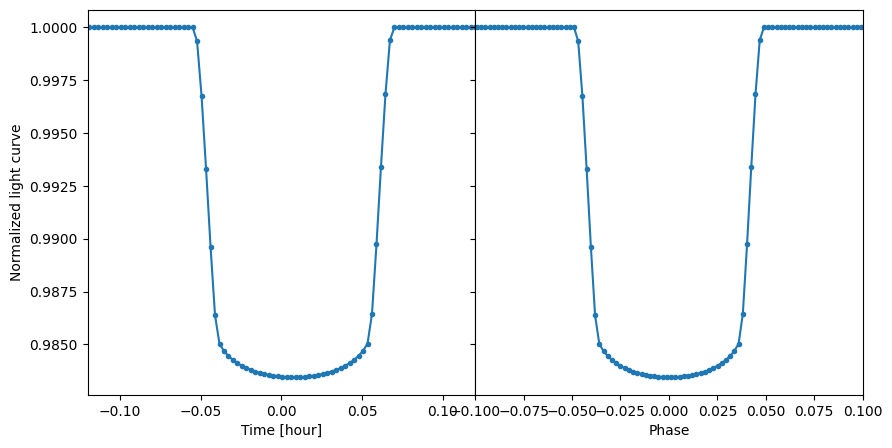

In [6]:
#WASP 121b


fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10,5))
fig.subplots_adjust(wspace=0)
print(len(LC_T_1))
print(len(tt_1))
ax2.plot(tt_1-0.63, LC_T_1, '.-')
ax2.set_xlabel('Time [hour]')
ax2.set_ylabel('Normalized light curve')
#ax2.set_xlim(t0_1-T14_1, t0_1+T14_1)
ax2.set_xlim(-0.12,0.12)

ax3.plot(phase_1-0.5, LC_T_1, '.-')
ax3.set_xlabel('Phase')
#ax3.set_xlim(0.5 - T14_1/planet_1.period, 0.5 + T14_1/planet_1.period)
ax3.set_xlim(-0.1, 0.1)

#possiamo notare nel grafico sotto come la funzione di LC(Time) sia centrata in 0.65, un valore basso rispetto al pianeta HD 209458b

Next, we estimate
1. Eclipse depth
2. Light curve adding the eclipse to the transit light curve. Remember that during the eclipse, the normalised light curve is 1, because in eclipse we only see the flux from the star

The eclipse depth is estimated assuming that we are observing in the IR and what we measure is the planet self emission from its dayside.

HD 209458b 

ret 37585.66954430048
ret 1191471.984179898
Eclipse depth 461 ppm 

WASP 121b 

ret 220482.00662059942
ret 1318699.7360772444
Eclipse depth 2592 ppm 

-------
0.9995394216037533 1.0
-------
LC_E:  [0.99953942 0.99953942 0.99953942 ... 0.99953942 0.99953942 0.99953942]
LC_T:  [1. 1. 1. ... 1. 1. 1.]
----------
LC_tot:  [1.00000021 1.00000021 1.00000021 ... 1.00000021 1.00000021 1.00000021]
----------
fp_over_fs 0.00046079062645435246
1-fp_over_rs:  0.9995392093735457
----------
----------
fp_over_fs_1 0.0025915878570561576
1-fp_over_rs_1:  0.9974084121429438


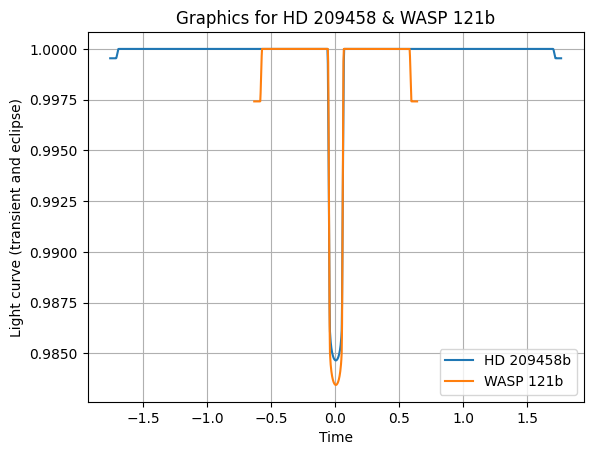

In [7]:
#the main idea is to calculate the eclipse and then compare it with the transit seen before
print('HD 209458b \n')
fp_over_fs = rp_over_rs**2 * Planck(wl, Tday)/Planck(wl, Tstar)
print("Eclipse depth {:.0f} ppm".format(1e6*fp_over_fs), '\n')
#print('which is three times smaller then the depth seen before -> 0.046% against 1.5%, so the transit depth is significantly larger then the eclipse one')
print('WASP 121b \n')
fp_over_fs_1 = rp_over_rs_1**2*Planck(wl, Tday_1)/Planck(wl,Tstar_1)
print("Eclipse depth {:.0f} ppm".format(1e6*fp_over_fs_1), '\n')
LC_E = plc.eclipse(fp_over_fs, rp_over_rs, period, sma_over_rs, ecc, inc, 0.0, t0, tt+t0)
LC_E_1 = plc.eclipse(fp_over_fs_1, rp_over_rs_1, period_1, sma_over_rs_1, ecc_1, inc_1, 0.0, t0_1, tt_1+t0_1)


#plt.plot(tt-1.755, (LC_E+LC_T-1+fp_over_fs-0.0004607906264544)-1)
#plt.plot(tt_1-0.624, (LC_E_1+LC_T_1-1+fp_over_fs_1-0.0025915878570562)-1)

plt.plot(tt-1.757, LC_E+LC_T-1+fp_over_fs-0.0004607906264544, label="HD 209458b") #ho usato uno shift per posizionare meglio il grafico su 1
plt.plot(tt_1-0.632, LC_E_1+LC_T_1-1+fp_over_fs_1-0.0025915878570562, label="WASP 121b") #stesso qui
plt.grid()
plt.xlabel('Time')
plt.ylabel('Light curve (transient and eclipse)')
plt.title('Graphics for HD 209458 & WASP 121b')
plt.legend(loc="lower right")


#plt.plot(tt, LC_E+LC_T-1+fp_over_fs)
#plt.plot(tt_1, LC_E_1+LC_T_1-1+fp_over_fs_1-0.0023) #-0.023 usato solo per posizionare la funzione sullo stesso punto intorno a 1
#i need to add the eclipse depth part

# The following normalisation is required in order to...
# the eclipse to be normalised to unity
LC_tot = LC_T+LC_E + fp_over_fs - 1 #è molto simile in valore a LC_T per cui non cambia molto nella rappresentazione finale del grafico/NON è OK
LC_tot_1 = LC_T_1+LC_E_1 + fp_over_fs_1 - 1
print('-------')
print(min(LC_E), max(LC_E))
print('-------')
print('LC_E: ', LC_E)
print('LC_T: ', LC_T)
#print(LC_T_1, '\n', LC_E_1, '\n') #ci sono delle variazioni all'interno di LC_T_1 e LC_E_1
print('----------')
print('LC_tot: ', LC_T+LC_E+fp_over_fs-1)
print('----------')
print('fp_over_fs', fp_over_fs)
print('1-fp_over_rs: ', 1-fp_over_fs)



print('----------')
#print('LC_tot_1: ', LC_T_1+LC_E_1+fp_over_fs_1-1) #di conseguenza ci sono delle variazioni qui
print('----------')
print('fp_over_fs_1', fp_over_fs_1)

print('1-fp_over_rs_1: ', 1-fp_over_fs_1)

#plt.plot(tt, LC_tot)

#facendo lo zoom sull'asse x si nota la NON differenza tra il prima e il dopo
#plt.xlim(1.6, 2.0)

In [8]:
print(max(LC_tot), max(LC_tot_1))
print(max(LC_tot_1)-max(LC_tot))

1.0004607906264544 1.0025915878570562
0.002130797230601722


#Misura raggio del pianeta HD 209458b e WASP 121b
Con misura del raggio stesso fatto con i dati di database rispetto alla misura "manuale".

In [9]:
from decimal import Decimal, getcontext


print(max(LC_E+LC_T-1+fp_over_fs)-min(LC_E+LC_T-1+fp_over_fs))
#print(max(LC_E_1+LC_T_1-1+fp_over_fs_1-0.0023)-min(LC_E_1+LC_T_1-1+fp_over_fs_1-0.0023))
print(max(LC_E_1+LC_T_1-1+fp_over_fs_1)-min(LC_E_1+LC_T_1-1+fp_over_fs_1))

print('---------------------------- \n','SI NOTA UNA DIFFERENZA DI 0.001 AL VALORE DI TRANSIT DEPTH CHE POTREI ACCETTARE \n',
      'Questa differenza appare dal momento che sto misurando \n',
      'dei valori composti rispetto a valori esatti ottenuti da un database \n', '--------------------------')
print((rp_over_rs)**2)
print((rp_over_rs_1)**2, '\n', '----------------')

getcontext().prec = 8

print('Misuro il rapporto tra il dato ottenuto dal database e quello ottenuto misurando i grafici \n')
print('Ratio HD 209458b: ', ((rp_over_rs)**2)/(max(LC_E+LC_T-1+fp_over_fs)-min(LC_E+LC_T-1+fp_over_fs))) #differenza del 5%
print('Ratio WASP 121b:', ((rp_over_rs_1)**2)/(max(LC_E_1+LC_T_1-1+fp_over_fs_1)-min(LC_E_1+LC_T_1-1+fp_over_fs_1)), '\n') #differenza del 7%

print('Si osserva una differenza tra il transit depth del database e misurato del 5% per HD 209458b e del 7% per WASP 121b  \n', '----------------')

R_p = np.sqrt(max(LC_E+LC_T-1+fp_over_fs)-min(LC_E+LC_T-1+fp_over_fs))*(1.203*696340)
print('Raggio pianeta HD 209458b in R_j: ' ,R_p/69911) #che corrisponde a 1.48 R_j (corretto, nell'errore ma ora faremo un confronto con la misura data dal database)

R_P = (rp_over_rs)*(1.203*696340)
print('Check su raggio: ', R_P/69911) #più corretto rispetto alla misura "manuale" fatta sopra ma sempre ok
print('Raggio medio riportato da Wikipedia: ', 1.35, 'R_j', '\n') #https://it.wikipedia.org/wiki/HD_209458_b

R_p_1 = np.sqrt(max(LC_E_1+LC_T_1-1+fp_over_fs_1-0.0023)-min(LC_E_1+LC_T_1-1+fp_over_fs_1-0.0023))*Rstar_1*696340
print('Raggio pianeta WASP 121b in R_j: ', R_p_1/69911)
R_P_1 = (rp_over_rs_1)*(1.458*696340)
print('Check su raggio: ', R_P_1/69911)
print('Raggio medio riportato da Wikipedia: ', 1.81, 'R_j') #https://en.wikipedia.org/wiki/WASP-121b

#0.016548761338412543
#0.015341720965835415

0.015341720965835415
0.016548761338412543
---------------------------- 
 SI NOTA UNA DIFFERENZA DI 0.001 AL VALORE DI TRANSIT DEPTH CHE POTREI ACCETTARE 
 Questa differenza appare dal momento che sto misurando 
 dei valori composti rispetto a valori esatti ottenuti da un database 
 --------------------------
0.0146071396
0.01550025 
 ----------------
Misuro il rapporto tra il dato ottenuto dal database e quello ottenuto misurando i grafici 

Ratio HD 209458b:  0.9521187116183862
Ratio WASP 121b: 0.936641098570999 

Si osserva una differenza tra il transit depth del database e misurato del 5% per HD 209458b e del 7% per WASP 121b  
 ----------------
Raggio pianeta HD 209458b in R_j:  1.484152390756069
Check su raggio:  1.4481850043226387
Raggio medio riportato da Wikipedia:  1.35 R_j 

Raggio pianeta WASP 121b in R_j:  1.868168733364423
Check su raggio:  1.8080178103588849
Raggio medio riportato da Wikipedia:  1.81 R_j


#HD 209458b phase plot

(0.9995392093735457, 1.0009215812529086)

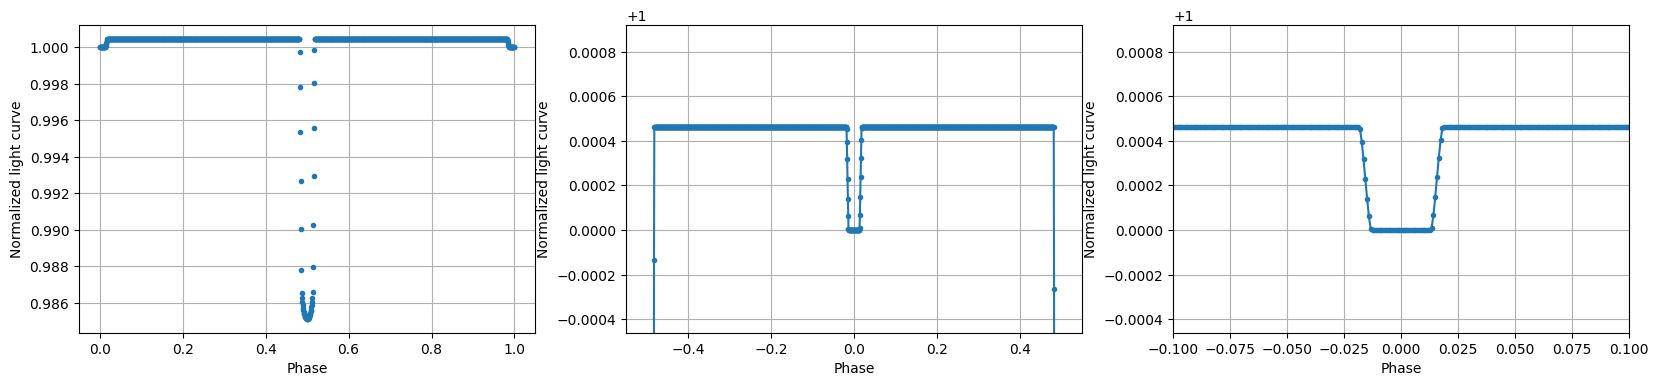

In [10]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax0.plot( phase, LC_tot, '.')
#ax0.plot( (phase+0.5)%1-0.5, LC_tot, '.')
ax0.set_xlabel('Phase')
ax0.set_ylabel('Normalized light curve')
ax0.grid()

ax1.plot( (phase+0.5)%1-0.5, LC_tot, '.-')
ax1.set_xlabel('Phase')
ax1.set_ylabel('Normalized light curve')
ax1.grid()
ax1.set_ylim(1-fp_over_fs,1+2*fp_over_fs)

ax2.plot( (phase+0.5)%1-0.5, LC_tot, '.-')
ax2.set_xlabel('Phase')
ax2.set_ylabel('Normalized light curve')
ax2.grid()
ax2.set_xlim(-0.1, 0.1)
ax2.set_ylim(1-fp_over_fs,1+2*fp_over_fs)

#WASP 121b phase plot


(0.9974084121429438, 1.0051831757141123)

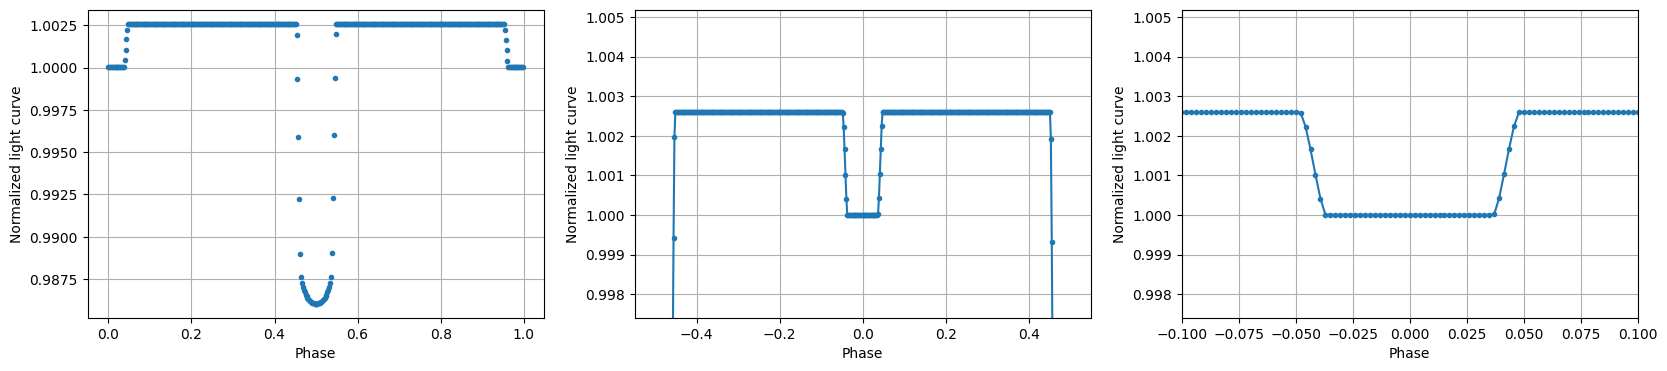

In [11]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax0.plot( phase_1, LC_tot_1, '.')
#ax0.plot( (phase+0.5)%1-0.5, LC_tot, '.')
ax0.set_xlabel('Phase')
ax0.set_ylabel('Normalized light curve')
ax0.grid()

ax1.plot( (phase_1+0.5)%1-0.5, LC_tot_1, '.-')
ax1.set_xlabel('Phase')
ax1.set_ylabel('Normalized light curve')
ax1.grid()
ax1.set_ylim(1-fp_over_fs_1,1+2*fp_over_fs_1)



ax2.plot( (phase_1+0.5)%1-0.5, LC_tot_1, '.-')
ax2.set_xlabel('Phase')
ax2.set_ylabel('Normalized light curve')
ax2.grid()
ax2.set_xlim(-0.1, 0.1)
ax2.set_ylim(1-fp_over_fs_1,1+2*fp_over_fs_1)

Finally, estimate the full light curve, adding the phase curve to the light curve.

The phase curve is estimated as in [Burrows et al. (2008)](https://iopscience.iop.org/article/10.1086/533518/pdf):

$$PC = \frac{R_p^2}{R_*^2}\left[\frac{I_{day}+I_{night}}{2 I_*}+\frac{I_{day}-I_{night}}{2 I_*} \cos(\Phi + \Phi_0)\cos(i)\right] $$

THE MODULATION B/W DAY AND NIGHT IS MADE BY THE TEMPERATURE

where $\Phi_0$ is the phase offset relative to the sub-stellar point.

During eclipse, we see the star, so we can multiply PC by a light curve defined between 0 and 1, with the shape of the eclipse. We can obtain this by estimating an eclipse light curve with infinite eclipse depth, or scaling the eclipse light curve obtained earlier between 0 and 1. Here we go for the former.

Finally, addig the transit light curve gives the estimate of the light curve over the full planet orbit.

**Note**: I neglect the reflected component. If you want, you can add the reflected component to the day-side emission component to have all effects included.


ret 37585.66954430048
ret 1191471.984179898
ret 4690.829442852174
ret 1191471.984179898
---------------------
ret 220482.00662059942
ret 1318699.7360772444
ret 3044.5958545545845
ret 1318699.7360772444


[0.00041156 0.00041091 0.00041025 ... 0.00041345 0.0004128  0.00041215] 
 Iday:  0.03154557559334563 
 Inight:  0.0039370035595767015 
 Kday:  0.0004607906264543524 
 Knight:  5.750836060043379e-05 

-------n--------
[2.27959287e-03 2.26804867e-03 2.25632561e-03 2.24442590e-03
 2.23235177e-03 2.22010547e-03 2.20768931e-03 2.19510561e-03
 2.18235672e-03 2.16944505e-03 2.15637300e-03 2.14314303e-03
 2.12975762e-03 2.11621927e-03 2.10253052e-03 2.08869394e-03
 2.07471213e-03 2.06058769e-03 2.04632328e-03 2.03192157e-03
 2.01738526e-03 2.00271708e-03 1.98791977e-03 1.97299611e-03
 1.95794888e-03 1.94278093e-03 1.92749507e-03 1.91209419e-03
 1.89658116e-03 1.88095890e-03 1.86523033e-03 1.84939839e-03
 1.83346606e-03 1.81743633e-03 1.80131218e-03 1.78509666e-03
 1.76879279e-03 1.75240363e-03

'\nplt.plot(tt,PhaseCurve)\nplt.plot(tt_1, PhaseCurve_1)\n'

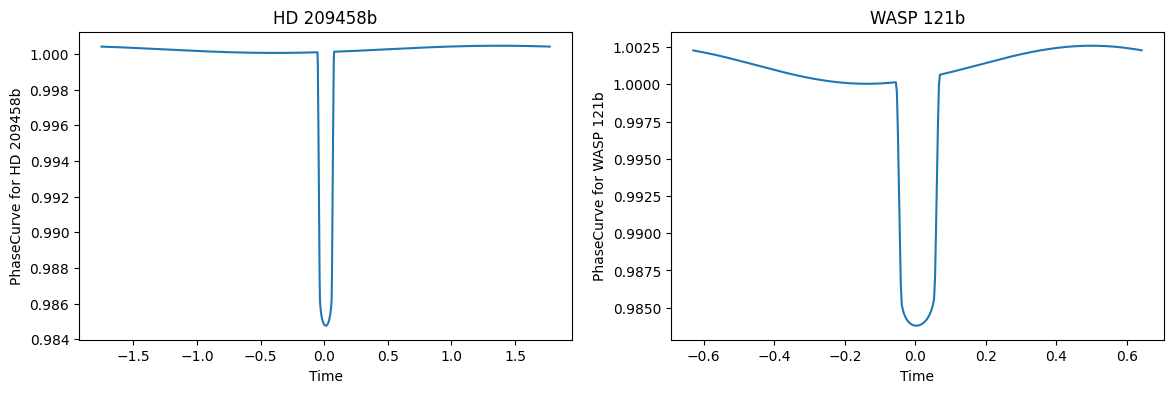

In [12]:
#i need to modulate the dotted line in the plots above
#i expect to see a modulation made by the cosine (see the equation above) The modulation is maximum conciding the eclipse and max coinciding to the transit

#------------------------------------------

#devo printare per HD209458b

Iday = Planck(wl, Tday)/Planck(wl, Tstar)
Inight = Planck(wl, Tnight)/Planck(wl, Tstar)
kday = rp_over_rs**2 * Iday
knight = rp_over_rs**2 * Inight

PhaseCurve = 0.5*(kday+knight) + 0.5*(kday-knight)*np.cos(2*np.pi*phase + np.deg2rad(phi0))

#LC_E = plc.eclipse(1e99, rp_over_rs, period, sma_over_rs, ecc, inc, 0.0, t0, tt+t0)

#print('new LC_E: ', LC_E, '\n')

PhaseCurveTot = PhaseCurve*LC_E + LC_T

print('---------------------')


#plt.plot((phase+0.5)%1-0.5, PhaseCurve*LC_E+1, '.')
#plt.plot((phase+0.5)%1-0.5, LC_T, '.')

#-----------------------------------------

#devo printare anche per WASP 121b

Iday_1 = Planck(wl, Tday_1)/Planck(wl, Tstar_1)
Inight_1 = Planck(wl, Tnight_1)/Planck(wl, Tstar_1)
kday_1 = rp_over_rs_1**2 * Iday_1
knight_1 = rp_over_rs_1**2 * Inight_1

PhaseCurve_1 = 0.5*(kday_1+knight_1) + 0.5*(kday_1-knight_1)*np.cos(2*np.pi*phase_1 + np.deg2rad(phi0_1))
print('\n')
print(PhaseCurve, '\n', 'Iday: ',Iday, '\n','Inight: ', Inight, '\n','Kday: ', kday, '\n','Knight: ', knight, '\n')
print('-------n--------')
print(PhaseCurve_1, '\n', 'Iday_1: ', Iday_1, '\n','Inight_1: ', Inight_1, '\n','Kday_1', kday_1, '\n','Knight_1: ', knight_1, '\n')


#LC_E_1 = plc.eclipse(1e99, rp_over_rs_1, period_1, sma_over_rs_1, ecc_1, inc_1, 0.0, t0_1, tt_1+t0_1)

PhaseCurveTot_1 = PhaseCurve_1*LC_E_1 + LC_T_1

print('------------------------------------------------------------------------------------')

print('PhaseCurveTot per HD: ',PhaseCurveTot, '\n')
print('PhaseCurveTot_1 per WASP: ', PhaseCurveTot_1, '\n')

print('------------------------------------------------------------------------------------')

print('I dati relativi ad HD sono più lineari, come si evince dalla stampa dei risultati')


fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(14,4))
ax0.plot(tt-1.75, PhaseCurveTot) #modulato per centrare la funzione
ax0.set_ylabel('PhaseCurve for HD 209458b')
ax0.set_title('HD 209458b')
ax0.set_xlabel('Time')

ax1.plot(tt_1-0.63, PhaseCurveTot_1) #modulato per centrare la funzione
ax1.set_title('WASP 121b')
ax1.set_ylabel('PhaseCurve for WASP 121b')
ax1.set_xlabel('Time')

"""
plt.plot(tt,PhaseCurve)
plt.plot(tt_1, PhaseCurve_1)
"""

Se la modulazione della curva di luce rispetto al tempo è maggiore, ciò implica che ci sono variazioni più evidenti e significative nella luminosità della stella o del sistema stella-pianeta nel corso dell'orbita del pianeta.

Le maggiori variazioni nella curva di luce possono essere causate da diversi fattori astronomici, tra cui:

1. Pianeti più grandi o vicini: Se il pianeta è grande o si trova molto vicino alla sua stella ospite, le variazioni nella luminosità saranno più pronunciate. Pianeti massicci e prossimi alla stella possono causare maggiori deformazioni gravitazionali sulla superficie della stella, che si traducono in variazioni nella luminosità osservata.
2. Pianeti con orbite più corte: I pianeti con orbite più brevi intorno alla loro stella avranno un periodo di transito più breve, quindi le variazioni nella luminosità saranno più frequenti e più ripide.
3. Pianeti con superfici riflettenti: Se il pianeta ha una superficie altamente riflettente o una copertura di nuvole, può riflettere una maggiore quantità di luce dalla sua stella, causando un maggiore cambiamento di luminosità durante il transito.
4. Pianeti con atmosfere dinamiche: I pianeti con atmosfere dinamiche, come quelli con forti venti atmosferici, possono mostrare variazioni temporali nella luminosità poiché i modelli di nuvole e atmosferici cambiano al variare del tempo.

Quindi, se la modulazione della curva di luce è maggiore, questo suggerisce che $WASP$ $121b$ e il suo sistema stellare possono avere caratteristiche più interessanti e dinamiche, rendendo tali sistemi astronomici particolarmente interessanti per ulteriori studi e analisi.

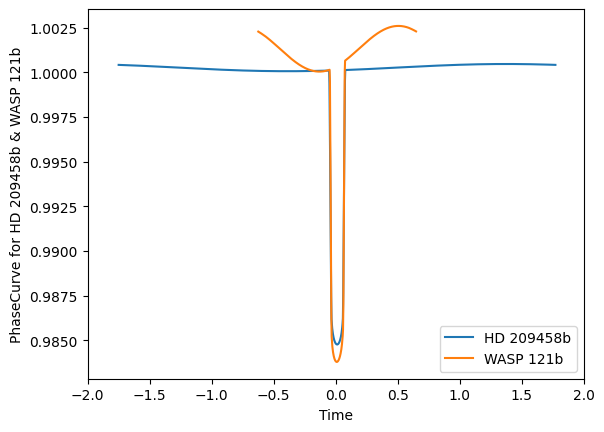

In [13]:
plt.plot(tt-1.75, PhaseCurveTot, label='HD 209458b')
plt.plot(tt_1-0.6239, PhaseCurveTot_1, label='WASP 121b')
plt.xlim(-2.0,2.0)
plt.ylabel('PhaseCurve for HD 209458b & WASP 121b')
plt.xlabel('Time')
plt.legend(loc='lower right')

La correzione osservata tra il grafico 3 e questo grafico mostra come ci sia una modifica nel grafico dovuta solo alla modulazione della curva di luce nel tempo, quindi sono più evidenti le variazioni di luminosità nel sistema pianeta-stella.

In [14]:
print(min(LC_T), min(LC_E))
print(max(LC_T), max(LC_E))
print(max(PhaseCurveTot), max(PhaseCurveTot_1))
print(max(PhaseCurveTot_1)-max(PhaseCurveTot))

0.9846582790341648 0.9995394216037533
1.0 1.0
1.0004607904689509 1.0025915843347792
0.002130793865828373


Le variazioni delle curve di fase dipendono proprio dal posizionamento del pianeta rispetto alla sua stella, e quindi della sua fase. I picchi di fase corrispondono a luminosità maggiori e quindi a eclissi o a momenti in cui il pianeta è nella fase "piena", mentre i punti più bassi corrispondono probabilmente a zone di "luna nuova".

Vantaggi:

Come i transiti, i segnali delle curve di fase sono impressi nelle misurazioni della luminosità stellare nel tempo, che sono molto più facili e meno costose da ottenere rispetto ai dati della velocità radiale perché le curve di fase possono essere ottenute con telescopi molto più piccoli e semplici strumenti. Le misurazioni delle curve di fase contengono anche molte più informazioni sul pianeta rispetto ai soli transiti.

Le variazioni ellissoidali, a differenza dei transiti, sono fortemente sensibili alla massa e all'eccentricità del pianeta. Sono un mezzo per misurare la massa del pianeta direttamente dalla curva di luce di una stella, senza bisogno di ottenere misurazioni di velocità radiale di follow-up. Inoltre, le variazioni ellissoidali sono osservabili anche quando un pianeta non transita, quindi potrebbero essere utilizzate per rilevare pianeti che non transitano.

Svantaggi:

Affinché i segnali di riflessione siano visibili, i pianeti devono essere grandi rispetto alle loro stelle. Il metodo è orientato a trovare "giovi caldi" - grandi pianeti vicini con brevi periodi orbitali. Allo stesso modo, le variazioni ellissoidali e i segnali di rinculo relativistico sono più forti per i pianeti pesanti e vicini.

In [15]:
PhaseCurve = 0.5*(kday+knight) + 0.5*(kday-knight)*np.cos(2*np.pi*phase + np.deg2rad(phi0))

LC_E = plc.eclipse(1e99, rp_over_rs, period, sma_over_rs, ecc, inc, 0.0, t0, tt+t0)


PhaseCurveTot = PhaseCurve*LC_E + LC_T

PhaseCurve_1 = 0.5*(kday_1+knight_1) + 0.5*(kday_1-knight_1)*np.cos(2*np.pi*phase_1 + np.deg2rad(phi0_1))

LC_E_1 = plc.eclipse(1e99, rp_over_rs_1, period_1, sma_over_rs_1, ecc_1, inc_1, 0.0, t0_1, tt_1+t0_1)

PhaseCurveTot_1 = PhaseCurve_1*LC_E_1 + LC_T_1

(0.9995392093735457, 1.0009215812529086)

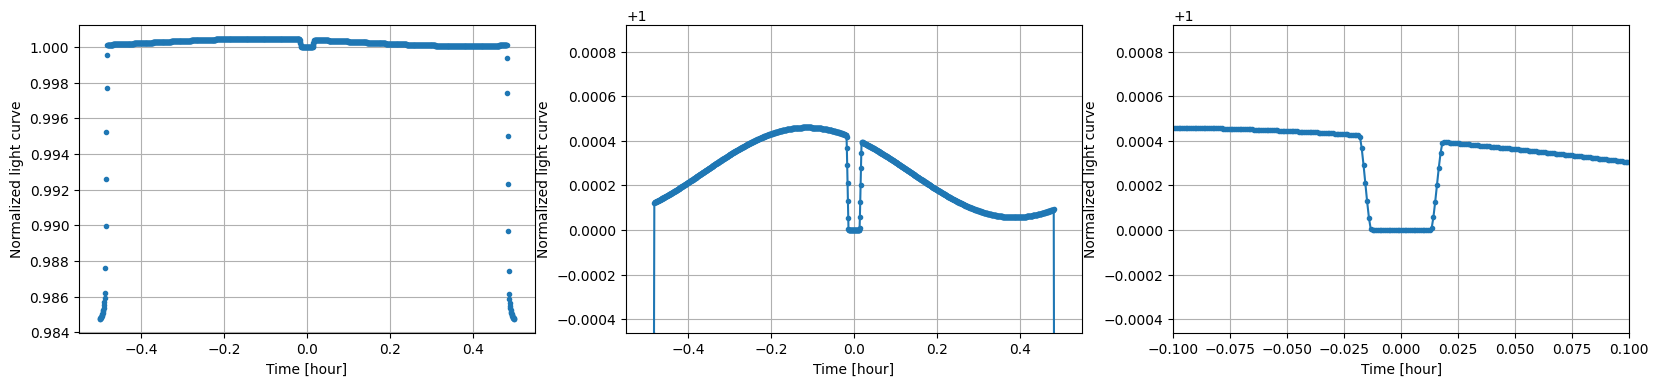

In [16]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax0.plot( (phase+0.5)%1-0.5, PhaseCurveTot, '.')
ax0.set_xlabel('Time [hour]')
ax0.set_ylabel('Normalized light curve')
ax0.grid()

ax1.plot( (phase+0.5)%1-0.5, PhaseCurveTot, '.-')
ax1.set_xlabel('Time [hour]')
ax1.set_ylabel('Normalized light curve')
ax1.grid()
ax1.set_ylim(1-fp_over_fs,1+2*fp_over_fs)

ax2.plot( (phase+0.5)%1-0.5, PhaseCurveTot, '.-')
ax2.set_xlabel('Time [hour]')
ax2.set_ylabel('Normalized light curve')
ax2.grid()
ax2.set_xlim(-0.1, 0.1)
ax2.set_ylim(1-fp_over_fs,1+2*fp_over_fs)

#R_P_phase = np.sqrt(max(PhaseCurveTot) - min(PhaseCurveTot))*(1.203)*696340

#R_p_j = R_P_phase/69911
#print(R_p_j)

#print('Con questo tipo di calcolo il valore sul raggio viene molto più approssimato rispetto alla realtà')

#the phase shifted the correction

(0.9974084121429438, 1.0051831757141123)

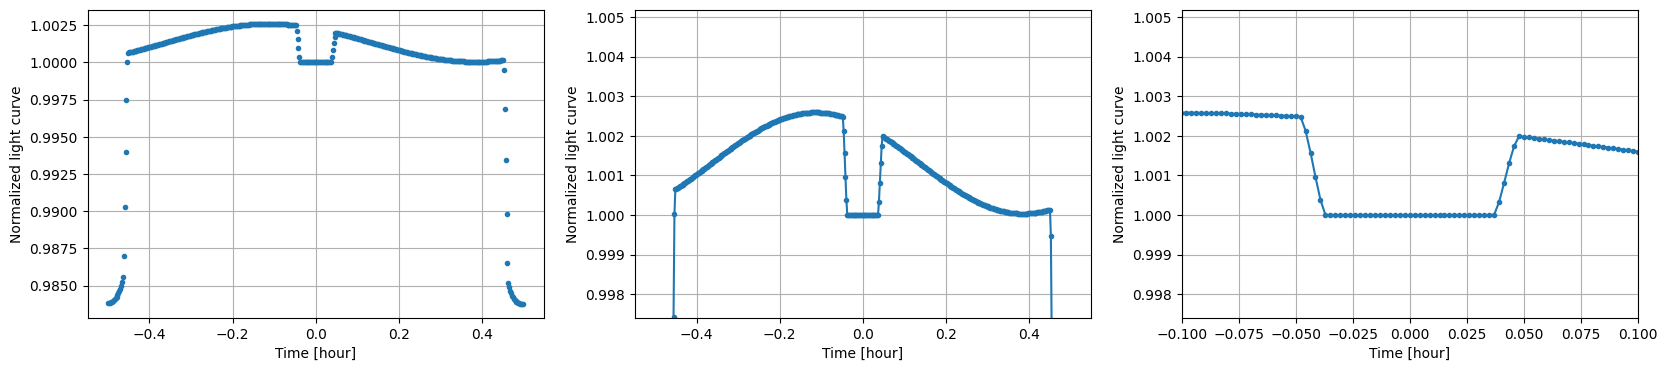

In [17]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(20,4))
ax0.plot( (phase_1+0.5)%1-0.5, PhaseCurveTot_1, '.')
ax0.set_xlabel('Time [hour]')
ax0.set_ylabel('Normalized light curve')
ax0.grid()

ax1.plot( (phase_1+0.5)%1-0.5, PhaseCurveTot_1, '.-')
ax1.set_xlabel('Time [hour]')
ax1.set_ylabel('Normalized light curve')
ax1.grid()
ax1.set_ylim(1-fp_over_fs_1,1+2*fp_over_fs_1)

ax2.plot( (phase_1+0.5)%1-0.5, PhaseCurveTot_1, '.-')
ax2.set_xlabel('Time [hour]')
ax2.set_ylabel('Normalized light curve')
ax2.grid()
ax2.set_xlim(-0.1, 0.1)
ax2.set_ylim(1-fp_over_fs_1,1+2*fp_over_fs_1)


#R_P_1_phase = np.sqrt(max(PhaseCurveTot_1) - min(PhaseCurveTot_1))*(1.458)*696340

#R_p_j = R_P_1_phase/69911
#print(R_p_j)

#print('Con questo calcolo il valore viene molto più approssimato rispetto alla realtà')


#print(((1.0025915843347792 - 1)**2)*696340)

#R_p_1 =((1.0025915843347792 - 1)**2)* Rstar_1*696340 #non sono sicuro dell'utilizzo delle unità di misura perché così sto esplicitando i km usando il raggio del sole ma non è una certezza
#print(R_p_1)

#print(R_p_1/69911)


#the phase shifted the correction
